## Collaborative filetering recommender system base on user ratings

In [18]:
import pandas as pd
import numpy as np

In [19]:
I = pd.read_csv('interactions.csv')
I.head()

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


In [20]:
I.isna().sum()
I.dropna(inplace=True)

In [21]:
count = I.groupby('recipe_id')['rating'].count()
count = count.reset_index()
count.columns = ['recipe_id', 'rating count']
count.head()

,recipe_id,rating count
0,38,4
1,39,1
2,40,9
3,41,2
4,43,1


In [22]:
count['rating count'].quantile(0.9)

9.0

In [23]:
import collections
def make_df_from_count(serie,name):
    counts = dict(collections.Counter(serie))
    return pd.DataFrame.from_dict(counts,orient='index').reset_index().rename(columns={'index':name,0:f'{name}_count'})

In [24]:
recipe_df = make_df_from_count(I.recipe_id,'recipe_id')
print(len(recipe_df))
recipe_df.head()

231630


,recipe_id,recipe_id_count
0,40893,2
1,44394,1
2,85009,2
3,120345,3
4,134728,7


Most of the recipes (39%) has only one review. Majority of them has less than 10 reviews (~90%)

In [25]:
small_than_two = len(recipe_df[recipe_df['recipe_id_count'] <2])/len(recipe_df)
small_than_five = len(recipe_df[recipe_df['recipe_id_count'] <5])/len(recipe_df) 
small_than_ten = len(recipe_df[recipe_df['recipe_id_count'] <10])/len(recipe_df) 
print(small_than_two, small_than_five, small_than_ten)

0.3969779389543669 0.7686396408064585 0.9076414972153866


In [26]:
user_df = make_df_from_count(I.user_id,'user_id')
print(len(user_df))
user_df.sort_values('user_id_count', ascending=False).head()

226419


,user_id,user_id_count
148,424680,7671
428,37449,5603
317,383346,4628
384,169430,4076
335,128473,3917


Most users (94.5%) do not have more than 10 reviews

In [27]:
len(user_df[user_df.user_id_count <10])/len(user_df)

0.9448544512607158

(array([223098.,   1621.,    546.,    285.,    869.]),
 array([  1. ,  40.8,  80.6, 120.4, 160.2, 200. ]),
 <BarContainer object of 5 artists>)

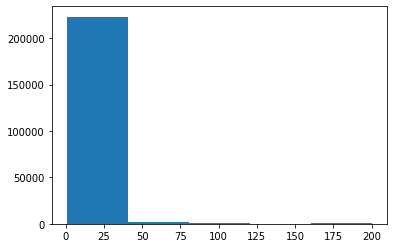

In [28]:
import matplotlib.pyplot as plt 
data = user_df.user_id_count.clip(0,200)
plt.hist(data, bins=5)

In [30]:
I['review'].head()

0    Great with a salad. Cooked on top of stove for...
1    So simple, so delicious! Great for chilly fall...
2    This worked very well and is EASY.  I used not...
3    I made the Mexican topping and took it to bunk...
4    Made the cheddar bacon topping, adding a sprin...
Name: review, dtype: object

In [31]:
import re
import string 
from nltk.stem import SnowballStemmer

# text = text.lower()
I['review'] = I['review'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '' , x))
#remove words and digits
I['review'] = I['review'].apply(lambda x: re.sub(r'[0-9]+', '', x))

#stemming
stemmer = SnowballStemmer(language='english')
def stem_words(text):
    return " ".join([stemmer.stem(word) for word in text.split()])
I['review'] = I['review'].apply(lambda x: stem_words(x))

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])
I['review'] = I['review'].apply(lambda text: lemmatize_words(text))

In [32]:
#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(I['review'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(1132198, 247420)

In [33]:
tfidf.get_feature_names()[5000:5010]

/Users/siyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['alotwhen',
 'alotwil',
 'alotwithout',
 'alotworthi',
 'alotyou',
 'alotyum',
 'alotzwt',
 'aloud',
 'alouett',
 'alout']

In [34]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

print(cosine_sim.shape)
print(cosine_sim[1])

In [ ]:
indices = pd.Series(I.index, index=I['recipe_id']).drop_duplicates()
indices[:10]

In [ ]:
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    recipe_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return I['recipe_id'].iloc[recipe_indices]

In [ ]:
#test
get_recommendations('134728')